# Classification

### Import Packages

In [1]:
!pip install bayesian-optimization

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import itertools
import gensim

import nltk
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from bayes_opt import BayesianOptimization
from tqdm import tqdm
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import TaggedDocument

from xgboost import XGBClassifier

p_stemmer = PorterStemmer() # initialize PorterStemmer

# Set seed for RNG
SEED = 12

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Fetching from Github

After further manual data-preprocessing, raw dataset is uploaded to Github and retrieved via url link.

In [2]:
# Retrieve dataset via url link
# Github Repo: https://github.com/X-Yang98/CE4045-NLP
overall_url = "https://raw.githubusercontent.com/xiao-yangg/CE4045-NLP/main/combined_dataset.csv"

overall_df = pd.read_csv(overall_url, encoding='latin') # train and test dataset

In [3]:
# Sanity check for any duplicates
overall_df.drop_duplicates(['tweet'], inplace=True)

# Add index column for identification
overall_df['index'] = list(overall_df.index)

Inter-annotator agreement for evaluation dataset.

In [4]:
no_disagreements = len(overall_df[((overall_df['label_1'] != overall_df['label_2']) | 
                                (overall_df['label_2'] != overall_df['label_3']) |
                                (overall_df['label_3'] != overall_df['label_1'])
                               )])

print("Inter-annotator agreement is {}%.".format((len(overall_df) - no_disagreements)/len(overall_df)*100))

Inter-annotator agreement is 89.29166666666667%.


General function to display sentiment and sentence length distribution.

In [5]:
def show_distribution(label, tweets, name):
    plt.figure(figsize=(18,6))

    # Bar graph visualisation of sentiment distribution
    plt.subplot(1,2,1)
    sns.countplot(x=label)
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.title("Sentiments Distribution in " + name + " Dataset")

    # Bar graph visualisation of sentence length distribution
    plt.subplot(1,2,2)
    sns.histplot([len(s) for s in tweets], bins=100)
    plt.xlabel("Sentence Length")
    plt.ylabel("Count")
    plt.title("Sentence Length Distribution in " + name + " Dataset")

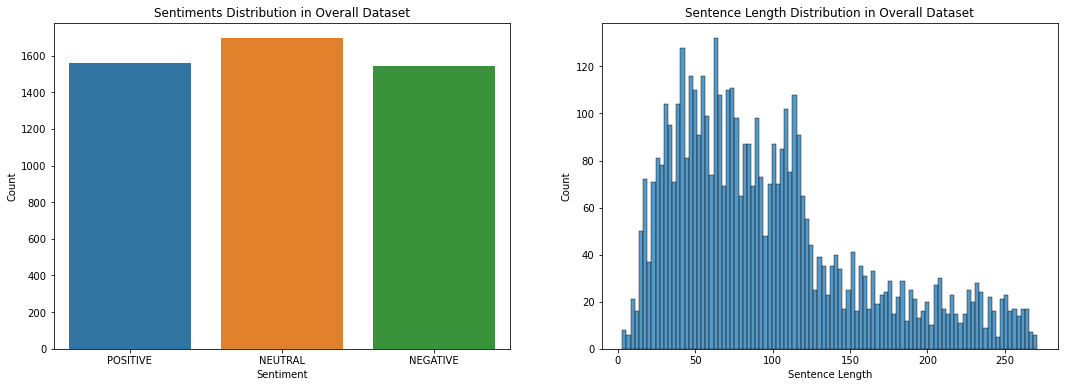

In [6]:
show_distribution(overall_df['final_label'], overall_df['tweet'], "Overall")

### Text Normalization


In [7]:
# Tokenization
def tokenize(text):
    return word_tokenize(text)

# Removal of Stopwords
def remove_stopword(text, length):
    nltk_tokenList = tokenize(text) # tokenize

    filtered_sentence = [] # sentence without stopwords
    nltk_stop_words = set(stopwords.words("english"))
    for w in nltk_tokenList:  
        if w not in nltk_stop_words:  
            filtered_sentence.append(w)
    
    if len(filtered_sentence) <= length:
        return text
    return ' '.join(filtered_sentence) # data tuning --> keep some stopwords

# Stemming
def stemming(token_list):
    stemmed_list = []
    for word in token_list:
        stemmed_list.append(p_stemmer.stem(word))

    return stemmed_list

# Lemmatization
def lemmatization(stemmed_list):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_list = []
    for word in stemmed_list:
        lemma_list.append(wordnet_lemmatizer.lemmatize(word))

    return lemma_list

# Combination of stemming and lemmatization
def nltk_process(text):
    nltk_tokenList = tokenize(text) # tokenize
    nltk_stemmedList = stemming(nltk_tokenList) # stemmed
    nltk_lemmaList = lemmatization(nltk_stemmedList) # lemma

    return ' '.join(nltk_tokenList)

Apply normalization to dataset.

In [8]:
# From Section 2, we noticed that for tweet length 8,13,16 have biggest jump in errors
# Hence we want to test how many stopwords to keep to retain context without overfitting
tweet_length=[8, 13, 16]

def normalize_df(df, length=tweet_length):    
    for l in length:
        df['len' + str(l) + '_tweet'] = df['tweet'].apply(remove_stopword, args = (l,)) # obtain tweet
        df['norm' + str(l) + '_tweet'] = df['len' + str(l) + '_tweet'].apply(nltk_process) # tweet go through stemming and lemma

    # New dataframe of text normalized tweets
    columns_titles = ['norm' + str(l) + '_tweet' for l in tweet_length] + ['final_label', 'index']
    return df.reindex(columns=columns_titles)

In [9]:
norm_df = normalize_df(overall_df)
norm_df.head()

,norm8_tweet,norm13_tweet,norm16_tweet,final_label,index
0,rebuilt from the sound up airpods pro buy now on,rebuilt from the sound up airpods pro buy now on,rebuilt from the sound up airpods pro buy now on,POSITIVE,0
1,early delivery,early delivery,early delivery,POSITIVE,1
2,i have to buy applewatch,i have to buy applewatch,i have to buy applewatch,POSITIVE,2
3,just the right size wearing the orange buying ...,just the right size wearing the orange buying ...,just the right size wearing the orange buying ...,POSITIVE,3
4,apple stay turning my headphones down every mi...,apple stay turning my headphones down every mi...,apple stay turning my headphones down every mi...,POSITIVE,4


### Split into train and test datasets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(norm_df[['norm' + str(l) + '_tweet' for l in tweet_length]], # tweet
                                                    norm_df[['final_label', 'index']], # label, index
                                                    test_size=0.25, # test size 25% 
                                                    random_state = SEED,
                                                    shuffle=True,
                                                    stratify=norm_df['final_label']) # ensure even proportion of Positive, Negative, Neutral in test data

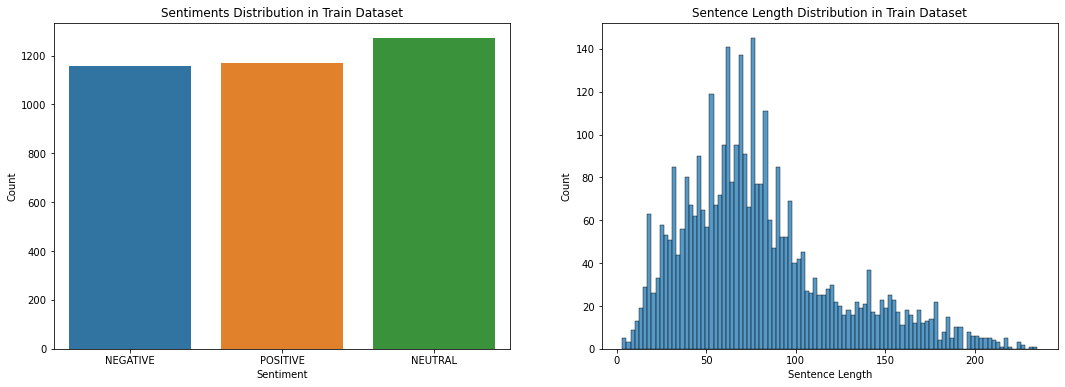

In [11]:
# 8 with stopword - Train
show_distribution(y_train['final_label'], X_train['norm8_tweet'], "Train")

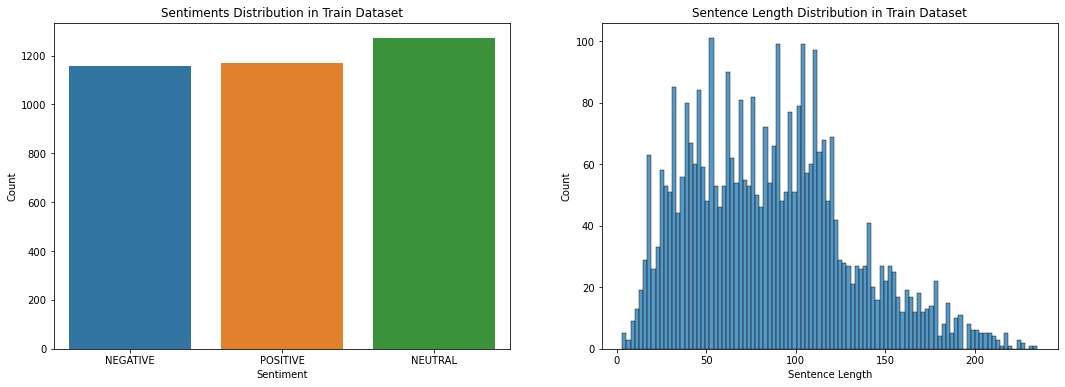

In [12]:
# 13 with stopword - Train
show_distribution(y_train['final_label'], X_train['norm13_tweet'], "Train")

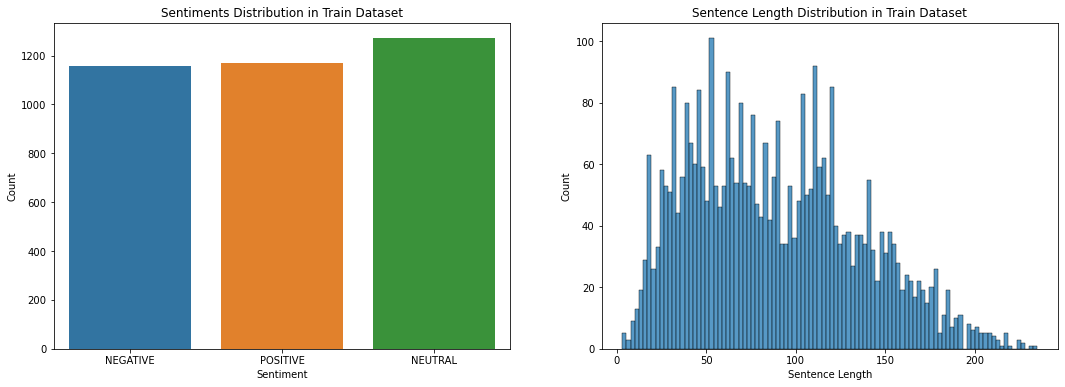

In [13]:
# 16 with stopword - Train
show_distribution(y_train['final_label'], X_train['norm16_tweet'], "Train")

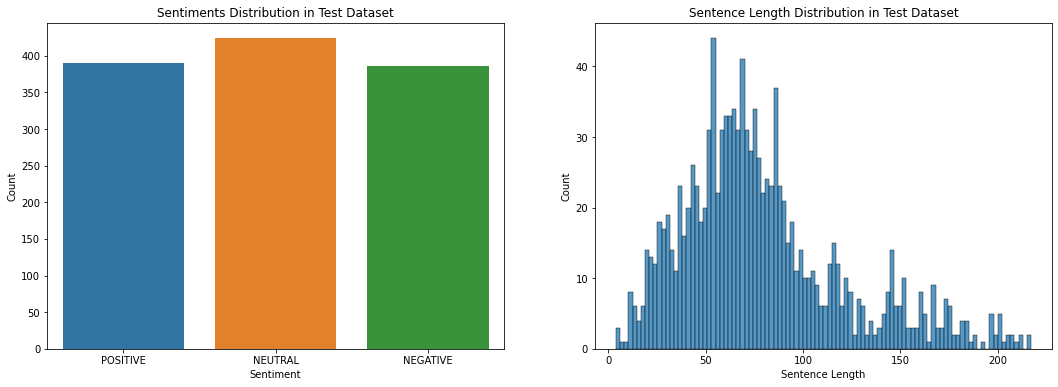

In [14]:
# 8 with stopword - Test
show_distribution(y_test['final_label'], X_test['norm8_tweet'], "Test")

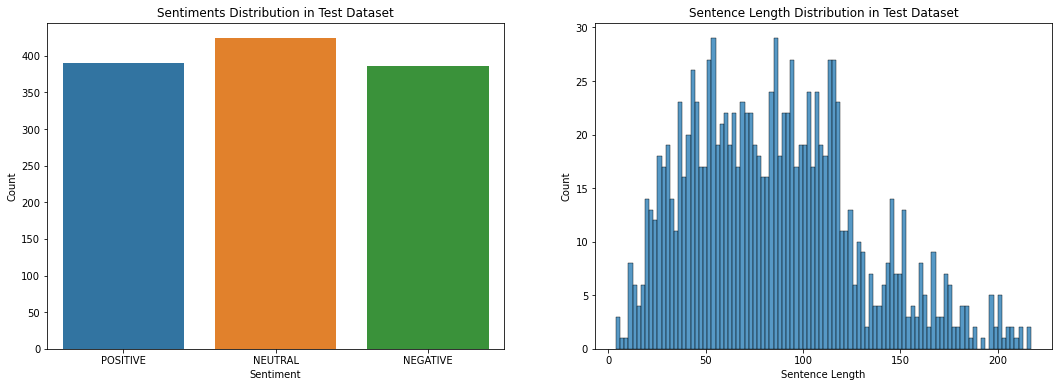

In [15]:
# 13 with stopword - Test
show_distribution(y_test['final_label'], X_test['norm13_tweet'], "Test")

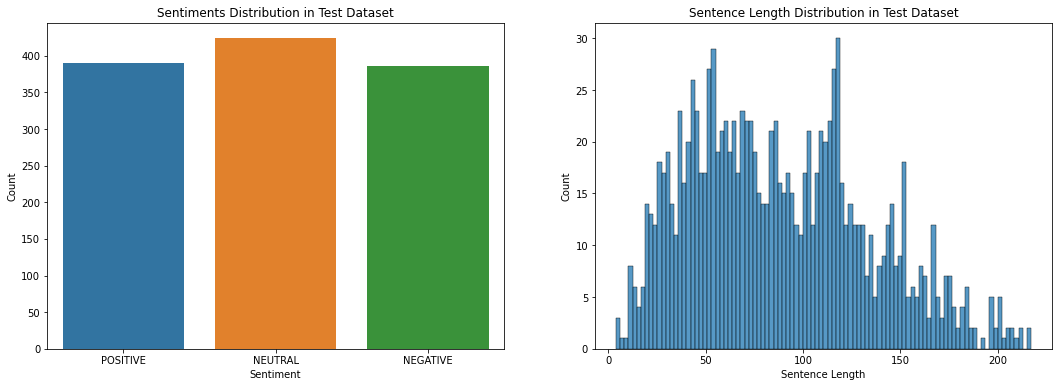

In [16]:
# 16 with stopword - Test
show_distribution(y_test['final_label'], X_test['norm16_tweet'], "Test")

### Model Helpers

#### Logs

Storing results for comparision.

In [17]:
logs = {
        'norm8_tweet': {'models': {}, 'metrics': {}},
        'norm13_tweet': {'models': {}, 'metrics': {}},
        'norm16_tweet': {'models': {}, 'metrics': {}},
       }

logs['norm8_tweet']['models']['X_test'] = list(X_test['norm8_tweet'])
logs['norm13_tweet']['models']['X_test'] = list(X_test['norm13_tweet'])
logs['norm16_tweet']['models']['X_test'] = list(X_test['norm16_tweet'])

logs['norm8_tweet']['models']['y_test'] = list(y_test['final_label'])
logs['norm13_tweet']['models']['y_test'] = list(y_test['final_label'])
logs['norm16_tweet']['models']['y_test'] = list(y_test['final_label'])

logs['norm8_tweet']['models']['index'] = list(y_test['index'])
logs['norm13_tweet']['models']['index'] = list(y_test['index'])
logs['norm16_tweet']['models']['index'] = list(y_test['index'])


# Remove index since we already stored
y_train = y_train['final_label']
y_test = y_test['final_label']

#### Vectorizers

TF-IDF Vectorizer

In [18]:
tfidf_vec8 = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7) 
tfidf_vec13 = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)  
tfidf_vec16 = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)  

# Using training data to transform text into counts of features for each tweet
tfidf_vec8.fit(X_train['norm8_tweet'])
tfidf_vec13.fit(X_train['norm13_tweet'])
tfidf_vec16.fit(X_train['norm16_tweet'])

TfidfVectorizer(max_df=0.7, max_features=2000, min_df=5)

In [19]:
labels = ['norm8_tweet', 'norm13_tweet', 'norm16_tweet']

#### Plots

General function for plotting accuracy and F1 metrics using different data tunings

In [20]:
def plot_line_graph_data_tuning(accuracy, f1s, labels): 
    colors = ['r', 'g', 'b', 'y']
    graph_type = ['_acc', '_f1']

    plt.figure(figsize=(12,8))

    for i in range(len(labels)):
        plt.plot(accuracy[i], marker='', color=colors[i], linewidth=2, linestyle='dashed', label=labels[i]+graph_type[0]) # accuracy line
        plt.plot(f1s[i], marker='', color=colors[i], linewidth=2, label=labels[i]+graph_type[1]) # f1 line
    plt.legend()
    plt.show()

General function for showing evaluation metrics.

In [21]:
def show_metrics(y_test, y_pred):

    # Adding classes names for interpretation
    classes_names = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                      columns=classes_names, index=classes_names)
                      
    # Visualize confusion matrix
    sns.heatmap(cm, annot=True, fmt='d');

    # Print classification report
    print(classification_report(y_test, y_pred))

### Traditional Machine Learning

In [22]:
X_train_dtm8 = tfidf_vec8.transform(X_train['norm8_tweet'])
X_train_dtm13 = tfidf_vec13.transform(X_train['norm13_tweet'])
X_train_dtm16 = tfidf_vec16.transform(X_train['norm16_tweet'])

X_test_dtm8 = tfidf_vec8.transform(X_test['norm8_tweet'])
X_test_dtm13 = tfidf_vec13.transform(X_test['norm13_tweet'])
X_test_dtm16 = tfidf_vec16.transform(X_test['norm16_tweet'])

#### K-Nearest Neighbors (KNN)

In [23]:
# norm8 tweet
knn_accuracy8 = []
knn_f1s8 = []

for i in range(1, 100):
    KNN = KNeighborsClassifier(n_neighbors = i)
    KNN.fit(X_train_dtm8, y_train)
    y_pred = KNN.predict(X_test_dtm8)

    knn_accuracy8.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    knn_f1s8.append(f1_score(y_test, y_pred, average='weighted'))

optimal_neighbors = knn_f1s8.index(max(knn_f1s8)) + 1
print("Optimal number of neighbors: ", optimal_neighbors)
print("Highest f1 score achieved: ", max(knn_f1s8))

##### Optimal K Value
# Accuracy using KNN model
KNN = KNeighborsClassifier(n_neighbors = optimal_neighbors)
KNN.fit(X_train_dtm8, y_train)
y_pred = KNN.predict(X_test_dtm8)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[0]]['models']['knn'] = list(y_pred)
logs[labels[0]]['metrics']['knn'] = {'accuracy': acc, 'f1 score': f1}

Optimal number of neighbors:  84
Highest f1 score achieved:  0.5647433044165986
Accuracy Score: 57.99999999999999%
F1 Score: 56.47433044165986%


In [24]:
# norm13 tweet
knn_accuracy13 = []
knn_f1s13 = []

for i in range(1, 100):
    KNN = KNeighborsClassifier(n_neighbors = i)
    KNN.fit(X_train_dtm13, y_train)
    y_pred = KNN.predict(X_test_dtm13)

    knn_accuracy13.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    knn_f1s13.append(f1_score(y_test, y_pred, average='weighted'))

optimal_neighbors = knn_f1s13.index(max(knn_f1s13)) + 1
print("Optimal number of neighbors: ", optimal_neighbors)
print("Highest f1 score achieved: ", max(knn_f1s13))

##### Optimal K Value
# Accuracy using KNN model
KNN = KNeighborsClassifier(n_neighbors = optimal_neighbors)
KNN.fit(X_train_dtm13, y_train)
y_pred = KNN.predict(X_test_dtm13)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[1]]['models']['knn'] = list(y_pred)
logs[labels[1]]['metrics']['knn'] = {'accuracy': acc, 'f1 score': f1}

Optimal number of neighbors:  96
Highest f1 score achieved:  0.5658143014102484
Accuracy Score: 58.08333333333333%
F1 Score: 56.58143014102484%


In [25]:
# norm16 tweet
knn_accuracy16 = []
knn_f1s16 = []

for i in range(1, 100):
    KNN = KNeighborsClassifier(n_neighbors = i)
    KNN.fit(X_train_dtm16, y_train)
    y_pred = KNN.predict(X_test_dtm16)

    knn_accuracy16.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    knn_f1s16.append(f1_score(y_test, y_pred, average='weighted'))

optimal_neighbors = knn_f1s16.index(max(knn_f1s16)) + 1
print("Optimal number of neighbors: ", optimal_neighbors)
print("Highest f1 score achieved: ", max(knn_f1s16))

##### Optimal K Value
# Accuracy using KNN model
KNN = KNeighborsClassifier(n_neighbors = optimal_neighbors)
KNN.fit(X_train_dtm16, y_train)
y_pred = KNN.predict(X_test_dtm16)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[2]]['models']['knn'] = list(y_pred)
logs[labels[2]]['metrics']['knn'] = {'accuracy': acc, 'f1 score': f1}

Optimal number of neighbors:  89
Highest f1 score achieved:  0.5780330375704892
Accuracy Score: 59.166666666666664%
F1 Score: 57.803303757048916%


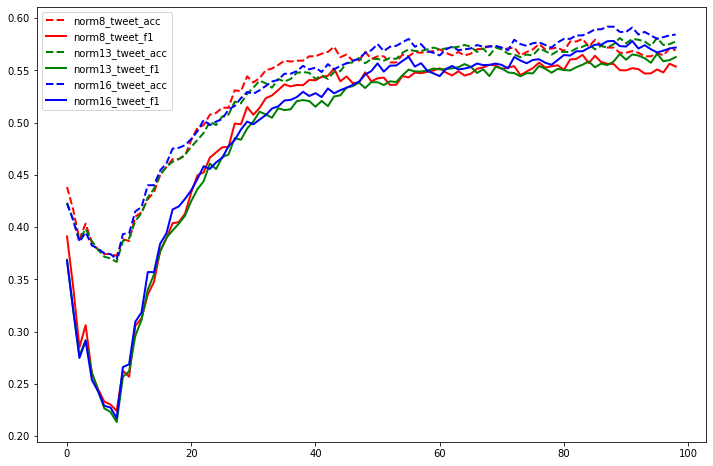

In [26]:
plot_line_graph_data_tuning([knn_accuracy8, knn_accuracy13, knn_accuracy16],
                            [knn_f1s8, knn_f1s13, knn_f1s16], labels)

#### Logistic Regression

In [27]:
# norm8 tweet
def opt_log(C):
    clf = LogisticRegression(solver = 'saga', multi_class = 'multinomial', C = C, random_state = SEED)
    clf.fit(X_train_dtm8, y_train)
    y_pred = clf.predict(X_test_dtm8)
    return f1_score(y_test, y_pred, average='weighted')

f1_8 = []
opt_C8 = []

params = {
    'C' : (0.1, 100)
}

opt = BayesianOptimization(f = opt_log, pbounds = params, verbose = 0)
opt.maximize(init_points = 10, n_iter = 10)

f1_8.append(opt.max['target'])
opt_C8.append(opt.max['params']['C'])

optimal_C = max(opt_C8)
print("The optimal C for logistic regression model: ", optimal_C)
print("Highest f1 score achieved: ", max(f1_8))

##### Optimal C
optimal_log = LogisticRegression(solver = 'saga', C = optimal_C, multi_class = 'multinomial', random_state = SEED)
optimal_log.fit(X_train_dtm8, y_train)
y_pred = optimal_log.predict(X_test_dtm8)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# uncomment this if planning to run streamlit as this model will be loaded in the UI as a sample
# pickle.dump(optimal_log, open("/content/logistic_classifier.pkl", "wb"))

# Store results
logs[labels[0]]['models']['logreg'] = list(y_pred)
logs[labels[0]]['metrics']['logreg'] = {'accuracy': acc, 'f1 score': f1}

The optimal C for logistic regression model:  3.299194320736583
Highest f1 score achieved:  0.6893509377400862
Accuracy Score: 69.0%
F1 Score: 68.93509377400862%


In [28]:
# norm13 tweet
def opt_log(C):
    clf = LogisticRegression(solver = 'saga', multi_class = 'multinomial', C = C, random_state = SEED)
    clf.fit(X_train_dtm13, y_train)
    y_pred = clf.predict(X_test_dtm13)
    return f1_score(y_test, y_pred, average='weighted')

f1_13 = []
opt_C13 = []

params = {
    'C' : (0.1, 100)
}

opt = BayesianOptimization(f = opt_log, pbounds = params, verbose = 0)
opt.maximize(init_points = 10, n_iter = 10)

f1_13.append(opt.max['target'])
opt_C13.append(opt.max['params']['C'])

optimal_C = max(opt_C13)
print("The optimal C for logistic regression model: ", optimal_C)
print("Highest f1 score achieved: ", max(f1_13))

##### Optimal C
optimal_log = LogisticRegression(solver = 'saga', C = optimal_C, multi_class = 'multinomial', random_state = SEED)
optimal_log.fit(X_train_dtm13, y_train)
y_pred = optimal_log.predict(X_test_dtm13)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# uncomment this if planning to run streamlit as this model will be loaded in the UI as a sample
# pickle.dump(optimal_log, open("/content/logistic_classifier.pkl", "wb"))

# Store results
logs[labels[1]]['models']['logreg'] = list(y_pred)
logs[labels[1]]['metrics']['logreg'] = {'accuracy': acc, 'f1 score': f1}

The optimal C for logistic regression model:  2.3757550079313994
Highest f1 score achieved:  0.6744980710240369
Accuracy Score: 67.58333333333333%
F1 Score: 67.4498071024037%


In [29]:
# norm16 tweet
def opt_log(C):
    clf = LogisticRegression(solver = 'saga', multi_class = 'multinomial', C = C, random_state = SEED)
    clf.fit(X_train_dtm16, y_train)
    y_pred = clf.predict(X_test_dtm16)
    return f1_score(y_test, y_pred, average='weighted')

f1_16 = []
opt_C16 = []

params = {
    'C' : (0.1, 100)
}

opt = BayesianOptimization(f = opt_log, pbounds = params, verbose = 0)
opt.maximize(init_points = 10, n_iter = 10)

f1_16.append(opt.max['target'])
opt_C16.append(opt.max['params']['C'])

optimal_C = max(opt_C16)
print("The optimal C for logistic regression model: ", optimal_C)
print("Highest f1 score achieved: ", max(f1_16))

##### Optimal C
optimal_log = LogisticRegression(solver = 'saga', C = optimal_C, multi_class = 'multinomial', random_state = SEED)
optimal_log.fit(X_train_dtm16, y_train)
y_pred = optimal_log.predict(X_test_dtm16)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# uncomment this if planning to run streamlit as this model will be loaded in the UI as a sample
# pickle.dump(optimal_log, open("/content/logistic_classifier.pkl", "wb"))

# Store results
logs[labels[2]]['models']['logreg'] = list(y_pred)
logs[labels[2]]['metrics']['logreg'] = {'accuracy': acc, 'f1 score': f1}

The optimal C for logistic regression model:  1.5539037222633203
Highest f1 score achieved:  0.6904809691341074
Accuracy Score: 69.16666666666667%
F1 Score: 69.04809691341075%


#### Naive Bayes Classifier

In [30]:
# norm8 tweet
#Train using Multinomial Naaive Bayes model
model = MultinomialNB()
model.fit(X_train_dtm8, y_train)

#Model accuracy
model.score(X_test_dtm8, y_test)
model_predictions = model.predict(X_test_dtm8)
print(classification_report(y_test, model_predictions))

#Hyperparemeter tuning of alpha
param = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1]}

#using gridsearch
clf=GridSearchCV(model,param, cv=10, return_train_score=True)

#fit model for grid search
clf.fit(X_train_dtm8, y_train)

#print best alpha
print(clf.best_params_)

##### Optimal Alpha Value
#alpha value = 0.00001
y_pred = clf.predict(X_test_dtm8)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[0]]['models']['nb'] = list(y_pred)
logs[labels[0]]['metrics']['nb'] = {'accuracy': acc, 'f1 score': f1}

              precision    recall  f1-score   support

    NEGATIVE       0.70      0.65      0.67       386
     NEUTRAL       0.66      0.76      0.71       424
    POSITIVE       0.66      0.61      0.63       390

    accuracy                           0.67      1200
   macro avg       0.67      0.67      0.67      1200
weighted avg       0.67      0.67      0.67      1200

{'alpha': 1}
Accuracy Score: 67.25%
F1 Score: 67.1040536010416%


In [31]:
# norm13 tweet
#Train using Multinomial Naaive Bayes model
model = MultinomialNB()
model.fit(X_train_dtm13, y_train)

#Model accuracy
model.score(X_test_dtm13, y_test)
model_predictions = model.predict(X_test_dtm13)
print(classification_report(y_test, model_predictions))

#Hyperparemeter tuning of alpha
param = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1]}

#using gridsearch
clf=GridSearchCV(model,param, cv=10, return_train_score=True)

#fit model for grid search
clf.fit(X_train_dtm13, y_train)

#print best alpha
print(clf.best_params_)

##### Optimal Alpha Value
#alpha value = 0.00001
y_pred = clf.predict(X_test_dtm13)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[1]]['models']['nb'] = list(y_pred)
logs[labels[1]]['metrics']['nb'] = {'accuracy': acc, 'f1 score': f1}

              precision    recall  f1-score   support

    NEGATIVE       0.68      0.69      0.68       386
     NEUTRAL       0.67      0.74      0.70       424
    POSITIVE       0.67      0.59      0.63       390

    accuracy                           0.68      1200
   macro avg       0.68      0.67      0.67      1200
weighted avg       0.68      0.68      0.67      1200

{'alpha': 1}
Accuracy Score: 67.5%
F1 Score: 67.35362121155984%


In [32]:
# norm16 tweet
#Train using Multinomial Naaive Bayes model
model = MultinomialNB()
model.fit(X_train_dtm16, y_train)

#Model accuracy
model.score(X_test_dtm16, y_test)
model_predictions = model.predict(X_test_dtm16)
print(classification_report(y_test, model_predictions))

#Hyperparemeter tuning of alpha
param = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1]}

#using gridsearch
clf=GridSearchCV(model,param, cv=10, return_train_score=True)

#fit model for grid search
clf.fit(X_train_dtm16, y_train)

#print best alpha
print(clf.best_params_)

##### Optimal Alpha Value
#alpha value = 0.00001
y_pred = clf.predict(X_test_dtm16)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[2]]['models']['nb'] = list(y_pred)
logs[labels[2]]['metrics']['nb'] = {'accuracy': acc, 'f1 score': f1}

              precision    recall  f1-score   support

    NEGATIVE       0.67      0.69      0.68       386
     NEUTRAL       0.68      0.71      0.70       424
    POSITIVE       0.67      0.61      0.64       390

    accuracy                           0.67      1200
   macro avg       0.67      0.67      0.67      1200
weighted avg       0.67      0.67      0.67      1200

{'alpha': 0.1}
Accuracy Score: 66.58333333333334%
F1 Score: 66.5422960525894%


#### Support Vector Machine (SVM)

In [33]:
# norm8 tweet
# Finding best hyperparameters for SVM model
svmParams = {'C': [0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001], 'kernel': ['rbf', 'sigmoid', 'linear', 'poly']}
svmBestParam = GridSearchCV(SVC(), svmParams, refit=True, verbose=1)
svmBestParam.fit(X_train_dtm8, y_train)

# Printing the best hyperparameters and score
print("Best hyperparameters: ", svmBestParam.best_params_) # print best hyperparams
print("Best score: ", svmBestParam.best_score_) # print best score
print("")

# Testing and showing metrics
svmPred = svmBestParam.predict(X_test_dtm8)

acc = accuracy_score(y_test, svmPred) * 100
f1 = f1_score(y_test, svmPred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[0]]['models']['svm'] = list(svmPred)
logs[labels[0]]['metrics']['svm'] = {'accuracy': acc, 'f1 score': f1}

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best hyperparameters:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best score:  0.6619444444444444

Accuracy Score: 68.25%
F1 Score: 68.11793565461308%


In [34]:
# norm13 tweet
# Finding best hyperparameters for SVM model
svmParams = {'C': [0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001], 'kernel': ['rbf', 'sigmoid', 'linear', 'poly']}
svmBestParam = GridSearchCV(SVC(), svmParams, refit=True, verbose=1)
svmBestParam.fit(X_train_dtm13, y_train)

# Printing the best hyperparameters and score
print("Best hyperparameters: ", svmBestParam.best_params_) # print best hyperparams
print("Best score: ", svmBestParam.best_score_) # print best score
print("")

# Testing and showing metrics
svmPred = svmBestParam.predict(X_test_dtm13)

acc = accuracy_score(y_test, svmPred) * 100
f1 = f1_score(y_test, svmPred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[1]]['models']['svm'] = list(svmPred)
logs[labels[1]]['metrics']['svm'] = {'accuracy': acc, 'f1 score': f1}

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best hyperparameters:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best score:  0.675

Accuracy Score: 69.16666666666667%
F1 Score: 69.03598121427815%


In [35]:
# norm16 tweet
# Finding best hyperparameters for SVM model
svmParams = {'C': [0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001], 'kernel': ['rbf', 'sigmoid', 'linear', 'poly']}
svmBestParam = GridSearchCV(SVC(), svmParams, refit=True, verbose=1)
svmBestParam.fit(X_train_dtm16, y_train)

# Printing the best hyperparameters and score
print("Best hyperparameters: ", svmBestParam.best_params_) # print best hyperparams
print("Best score: ", svmBestParam.best_score_) # print best score
print("")

# Testing and showing metrics
svmPred = svmBestParam.predict(X_test_dtm16)

acc = accuracy_score(y_test, svmPred) * 100
f1 = f1_score(y_test, svmPred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[2]]['models']['svm'] = list(svmPred)
logs[labels[2]]['metrics']['svm'] = {'accuracy': acc, 'f1 score': f1}

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best hyperparameters:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best score:  0.6758333333333335

Accuracy Score: 69.66666666666667%
F1 Score: 69.5495403243713%


#### Decision Trees


In [36]:
# norm8 tweet
dt_accuracy8 = []
dt_f1s8 = []

for i in tqdm(range(1, 201)):
    dt = DecisionTreeClassifier(max_depth = i, random_state = SEED)
    dt.fit(X_train_dtm8, y_train)
    y_pred = dt.predict(X_test_dtm8)
    
    dt_accuracy8.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    dt_f1s8.append(f1_score(y_test, y_pred, average='weighted'))
    
optimal_dt_depth = dt_f1s8.index(max(dt_f1s8)) + 1
print("Optimal maximum depth: ", optimal_dt_depth)
print("Highest f1 score achieved: ", max(dt_f1s8))

##### Optimal Maximum Depth
# Accuracy using Decision Tree model
optimal_dt = DecisionTreeClassifier(max_depth = optimal_dt_depth, random_state = SEED)
optimal_dt.fit(X_train_dtm8, y_train)
y_pred = optimal_dt.predict(X_test_dtm8)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[0]]['models']['dectree'] = list(y_pred)
logs[labels[0]]['metrics']['dectree'] = {'accuracy': acc, 'f1 score': f1}

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:47<00:00,  4.25it/s]

Optimal maximum depth:  30
Highest f1 score achieved:  0.5704591900658108
Accuracy Score: 57.41666666666667%
F1 Score: 57.04591900658108%


In [37]:
# norm13 tweet
dt_accuracy13 = []
dt_f1s13 = []

for i in tqdm(range(1, 201)):
    dt = DecisionTreeClassifier(max_depth = i, random_state = SEED)
    dt.fit(X_train_dtm13, y_train)
    y_pred = dt.predict(X_test_dtm13)
    
    dt_accuracy13.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    dt_f1s13.append(f1_score(y_test, y_pred, average='weighted'))
    
optimal_dt_depth = dt_f1s13.index(max(dt_f1s13)) + 1
print("Optimal maximum depth: ", optimal_dt_depth)
print("Highest f1 score achieved: ", max(dt_f1s13))

##### Optimal Maximum Depth
# Accuracy using Decision Tree model
optimal_dt = DecisionTreeClassifier(max_depth = optimal_dt_depth, random_state = SEED)
optimal_dt.fit(X_train_dtm13, y_train)
y_pred = optimal_dt.predict(X_test_dtm13)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[1]]['models']['dectree'] = list(y_pred)
logs[labels[1]]['metrics']['dectree'] = {'accuracy': acc, 'f1 score': f1}

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:47<00:00,  4.19it/s]


Optimal maximum depth:  73
Highest f1 score achieved:  0.562615452997976
Accuracy Score: 56.333333333333336%
F1 Score: 56.261545299797596%


In [38]:
# norm16 tweet
dt_accuracy16 = []
dt_f1s16 = []

for i in tqdm(range(1, 201)):
    dt = DecisionTreeClassifier(max_depth = i, random_state = SEED)
    dt.fit(X_train_dtm16, y_train)
    y_pred = dt.predict(X_test_dtm16)
    
    dt_accuracy16.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    dt_f1s16.append(f1_score(y_test, y_pred, average='weighted'))
    
optimal_dt_depth = dt_f1s16.index(max(dt_f1s16)) + 1
print("Optimal maximum depth: ", optimal_dt_depth)
print("Highest f1 score achieved: ", max(dt_f1s16))

##### Optimal Maximum Depth
# Accuracy using Decision Tree model
optimal_dt = DecisionTreeClassifier(max_depth = optimal_dt_depth, random_state = SEED)
optimal_dt.fit(X_train_dtm16, y_train)
y_pred = optimal_dt.predict(X_test_dtm16)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[2]]['models']['dectree'] = list(y_pred)
logs[labels[2]]['metrics']['dectree'] = {'accuracy': acc, 'f1 score': f1}

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:45<00:00,  4.36it/s]


Optimal maximum depth:  53
Highest f1 score achieved:  0.5823008005021372
Accuracy Score: 58.25%
F1 Score: 58.230080050213715%


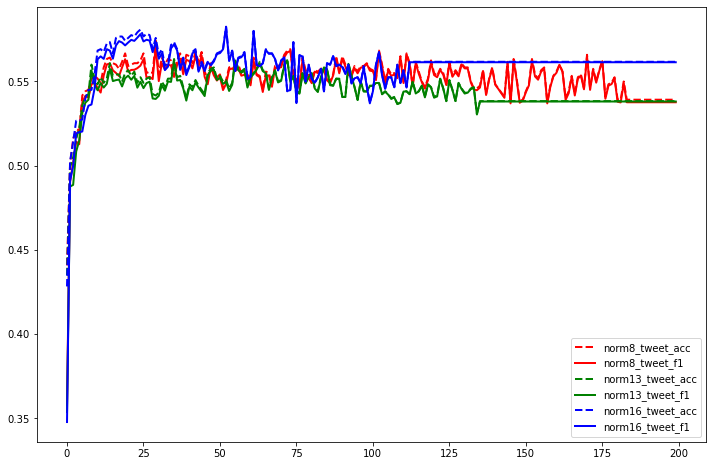

In [39]:
plot_line_graph_data_tuning([dt_accuracy8, dt_accuracy13, dt_accuracy16],
                            [dt_f1s8, dt_f1s13, dt_f1s16], labels)

#### Extra Trees Classifier


In [40]:
# norm8 tweet
et_accuracy8 = []
et_f1s8 = []

for i in tqdm(range(1, 101)):
    et_clf = ExtraTreesClassifier(max_depth = i, n_estimators = 250, random_state = SEED)
    et_clf.fit(X_train_dtm8, y_train)
    y_pred = et_clf.predict(X_test_dtm8)
    
    et_accuracy8.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    et_f1s8.append(f1_score(y_test, y_pred, average='weighted'))
    
optimal_et_depth = et_f1s8.index(max(et_f1s8)) + 1
print("Optimal maximum depth: ", optimal_et_depth)
print("Highest f1 score achieved: ", max(et_f1s8))

##### Optimal Maximum Depth
# Accuracy using ExtraTrees model
optimal_et = ExtraTreesClassifier(max_depth = optimal_et_depth, n_estimators = 250, random_state = SEED)
optimal_et.fit(X_train_dtm8, y_train)
y_pred = optimal_et.predict(X_test_dtm8)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[0]]['models']['extree'] = list(y_pred)
logs[labels[0]]['metrics']['extree'] = {'accuracy': acc, 'f1 score': f1}

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:51<00:00,  2.31s/it]


Optimal maximum depth:  97
Highest f1 score achieved:  0.696172848718655
Accuracy Score: 69.75%
F1 Score: 69.61728487186551%


In [41]:
# norm13 tweet
et_accuracy13 = []
et_f1s13 = []

for i in tqdm(range(1, 101)):
    et_clf = ExtraTreesClassifier(max_depth = i, n_estimators = 250, random_state = SEED)
    et_clf.fit(X_train_dtm13, y_train)
    y_pred = et_clf.predict(X_test_dtm13)
    
    et_accuracy13.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    et_f1s13.append(f1_score(y_test, y_pred, average='weighted'))
    
optimal_et_depth = et_f1s13.index(max(et_f1s13)) + 1
print("Optimal maximum depth: ", optimal_et_depth)
print("Highest f1 score achieved: ", max(et_f1s13))

##### Optimal Maximum Depth
# Accuracy using ExtraTrees model
optimal_et = ExtraTreesClassifier(max_depth = optimal_et_depth, n_estimators = 250, random_state = SEED)
optimal_et.fit(X_train_dtm13, y_train)
y_pred = optimal_et.predict(X_test_dtm13)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[1]]['models']['extree'] = list(y_pred)
logs[labels[1]]['metrics']['extree'] = {'accuracy': acc, 'f1 score': f1}

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:52<00:00,  2.33s/it]


Optimal maximum depth:  100
Highest f1 score achieved:  0.6962549905348996
Accuracy Score: 69.75%
F1 Score: 69.62549905348996%


In [42]:
# norm16 tweet
et_accuracy16 = []
et_f1s16 = []

for i in tqdm(range(1, 101)):
    et_clf = ExtraTreesClassifier(max_depth = i, n_estimators = 250, random_state = SEED)
    et_clf.fit(X_train_dtm16, y_train)
    y_pred = et_clf.predict(X_test_dtm16)
    
    et_accuracy16.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    et_f1s16.append(f1_score(y_test, y_pred, average='weighted'))
    
optimal_et_depth = et_f1s16.index(max(et_f1s16)) + 1
print("Optimal maximum depth: ", optimal_et_depth)
print("Highest f1 score achieved: ", max(et_f1s16))

##### Optimal Maximum Depth
# Accuracy using ExtraTrees model
optimal_et = ExtraTreesClassifier(max_depth = optimal_et_depth, n_estimators = 250, random_state = SEED)
optimal_et.fit(X_train_dtm16, y_train)
y_pred = optimal_et.predict(X_test_dtm16)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[2]]['models']['extree'] = list(y_pred)
logs[labels[2]]['metrics']['extree'] = {'accuracy': acc, 'f1 score': f1}

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:03<00:00,  2.44s/it]


Optimal maximum depth:  86
Highest f1 score achieved:  0.6869634960441289
Accuracy Score: 68.83333333333333%
F1 Score: 68.69634960441289%


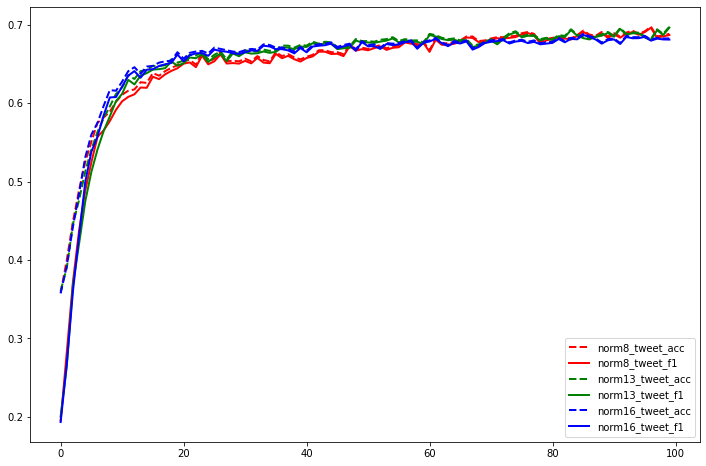

In [43]:
plot_line_graph_data_tuning([et_accuracy8, et_accuracy13, et_accuracy16],
                            [et_f1s8, et_f1s13, et_f1s16], labels)

#### Random Forest

In [44]:
# norm8 tweet
rand_forest_acc8 = list()
rand_forest_f1s8 = list()
for i in tqdm(range(10, 301, 10)):
    forest = RandomForestClassifier(n_estimators=i, oob_score=True, n_jobs=-1)
    forest.fit(X_train_dtm8, y_train)
    y_pred_i = forest.predict(X_test_dtm8)

    rand_forest_acc8.append(accuracy_score(y_test, y_pred_i))
    rand_forest_f1s8.append(f1_score(y_test, y_pred_i, average='weighted'))
    
optimal_trees = rand_forest_f1s8.index(max(rand_forest_f1s8)) + 1
print("Optimal number of trees: ", optimal_neighbors)
print("Highest f1 score achieved: ", max(rand_forest_f1s8))

##### Optimal No. of Trees
forest = RandomForestClassifier(n_estimators=optimal_trees, oob_score=True, n_jobs=-1)
forest.fit(X_train_dtm8, y_train)
y_pred = forest.predict(X_test_dtm8)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[0]]['models']['randforest'] = list(y_pred)
logs[labels[0]]['metrics']['randforest'] = {'accuracy': acc, 'f1 score': f1}

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:25<00:00,  1.19it/s]

Optimal number of trees:  89
Highest f1 score achieved:  0.6542728014868818
Accuracy Score: 61.83333333333333%
F1 Score: 61.62930907902563%


In [45]:
# norm13 tweet
rand_forest_acc13 = list()
rand_forest_f1s13 = list()
for i in tqdm(range(10, 301, 10)):
    forest = RandomForestClassifier(n_estimators=i, oob_score=True, n_jobs=-1)
    forest.fit(X_train_dtm13, y_train)
    y_pred_i = forest.predict(X_test_dtm13)

    rand_forest_acc13.append(accuracy_score(y_test, y_pred_i))
    rand_forest_f1s13.append(f1_score(y_test, y_pred_i, average='weighted'))
    
optimal_trees = rand_forest_f1s13.index(max(rand_forest_f1s13)) + 1
print("Optimal number of trees: ", optimal_neighbors)
print("Highest f1 score achieved: ", max(rand_forest_f1s13))

##### Optimal No. of Trees
forest = RandomForestClassifier(n_estimators=optimal_trees, oob_score=True, n_jobs=-1)
forest.fit(X_train_dtm13, y_train)
y_pred = forest.predict(X_test_dtm13)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[1]]['models']['randforest'] = list(y_pred)
logs[labels[1]]['metrics']['randforest'] = {'accuracy': acc, 'f1 score': f1}

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:24<00:00,  1.23it/s]

Optimal number of trees:  89
Highest f1 score achieved:  0.6627979348092305
Accuracy Score: 63.83333333333333%
F1 Score: 63.781453124147426%


In [46]:
# norm16 tweet
rand_forest_acc16 = list()
rand_forest_f1s16 = list()
for i in tqdm(range(10, 301, 10)):
    forest = RandomForestClassifier(n_estimators=i, oob_score=True, n_jobs=-1)
    forest.fit(X_train_dtm16, y_train)
    y_pred_i = forest.predict(X_test_dtm16)

    rand_forest_acc16.append(accuracy_score(y_test, y_pred_i))
    rand_forest_f1s16.append(f1_score(y_test, y_pred_i, average='weighted'))
    
optimal_trees = rand_forest_f1s16.index(max(rand_forest_f1s16)) + 1
print("Optimal number of trees: ", optimal_neighbors)
print("Highest f1 score achieved: ", max(rand_forest_f1s16))

##### Optimal No. of Trees
forest = RandomForestClassifier(n_estimators=optimal_trees, oob_score=True, n_jobs=-1)
forest.fit(X_train_dtm16, y_train)
y_pred = forest.predict(X_test_dtm16)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[2]]['models']['randforest'] = list(y_pred)
logs[labels[2]]['metrics']['randforest'] = {'accuracy': acc, 'f1 score': f1}

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:24<00:00,  1.22it/s]

Optimal number of trees:  89
Highest f1 score achieved:  0.6676911883131899
Accuracy Score: 62.916666666666664%
F1 Score: 62.79784639268087%


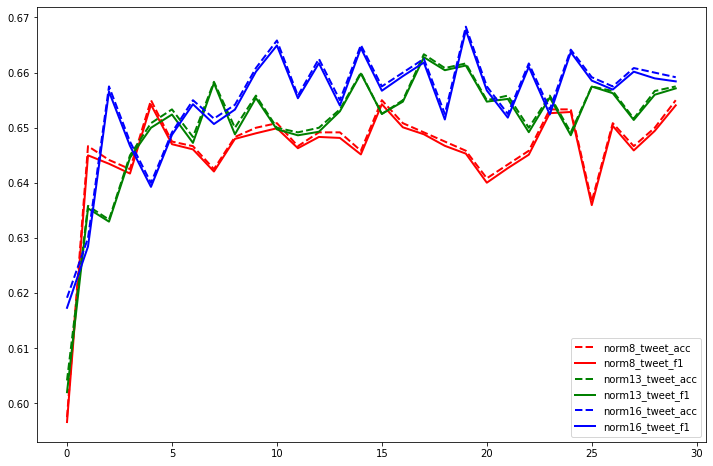

In [47]:
plot_line_graph_data_tuning([rand_forest_acc8, rand_forest_acc13, rand_forest_acc16],
                            [rand_forest_f1s8, rand_forest_f1s13, rand_forest_f1s16], labels)

#### XGBoost


In [48]:
# norm8 tweet
xgb_accuracy8 = []
xgb_f1s8 = []

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

for i in tqdm(range(1, 31)):
    xgb = XGBClassifier(max_depth = i, n_estimators = 250)
    xgb.fit(X_train_dtm8, y_train_encoded)
    y_pred_encoded = xgb.predict(X_test_dtm8)
    y_pred = le.inverse_transform(y_pred_encoded)
    
    xgb_accuracy8.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    xgb_f1s8.append(f1_score(y_test, y_pred, average='weighted'))
    
optimal_xgb_depth = xgb_f1s8.index(max(xgb_f1s8)) + 1
print("Optimal maximum depth: ", optimal_xgb_depth)
print("Highest f1 score achieved: ", max(xgb_f1s8))

##### Optimal Maximum Depth
# Accuracy using XGBoost model
optimal_xgb = XGBClassifier(max_depth = optimal_xgb_depth, n_estimators = 250)
optimal_xgb.fit(X_train_dtm8, y_train_encoded)
y_pred_encoded = optimal_xgb.predict(X_test_dtm8)
y_pred = le.inverse_transform(y_pred_encoded)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[0]]['models']['xgboost'] = list(y_pred)
logs[labels[0]]['metrics']['xgboost'] = {'accuracy': acc, 'f1 score': f1}

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [11:52<00:00, 23.74s/it]


Optimal maximum depth:  6
Highest f1 score achieved:  0.6727518931938522
Accuracy Score: 67.33333333333333%
F1 Score: 67.27518931938522%


In [49]:
# norm13 tweet
xgb_accuracy13 = []
xgb_f1s13 = []

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

for i in tqdm(range(1, 31)):
    xgb = XGBClassifier(max_depth = i, n_estimators = 250)
    xgb.fit(X_train_dtm13, y_train_encoded)
    y_pred_encoded = xgb.predict(X_test_dtm13)
    y_pred = le.inverse_transform(y_pred_encoded)
    
    xgb_accuracy13.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    xgb_f1s13.append(f1_score(y_test, y_pred, average='weighted'))
    
optimal_xgb_depth = xgb_f1s13.index(max(xgb_f1s13)) + 1
print("Optimal maximum depth: ", optimal_xgb_depth)
print("Highest f1 score achieved: ", max(xgb_f1s13))

##### Optimal Maximum Depth
# Accuracy using XGBoost model
optimal_xgb = XGBClassifier(max_depth = optimal_xgb_depth, n_estimators = 250)
optimal_xgb.fit(X_train_dtm13, y_train_encoded)
y_pred_encoded = optimal_xgb.predict(X_test_dtm13)
y_pred = le.inverse_transform(y_pred_encoded)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[1]]['models']['xgboost'] = list(y_pred)
logs[labels[1]]['metrics']['xgboost'] = {'accuracy': acc, 'f1 score': f1}

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [12:52<00:00, 25.75s/it]


Optimal maximum depth:  20
Highest f1 score achieved:  0.6778714528187392
Accuracy Score: 67.83333333333333%
F1 Score: 67.78714528187392%


In [50]:
# norm16 tweet
xgb_accuracy16 = []
xgb_f1s16 = []

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

for i in tqdm(range(1, 31)):
    xgb = XGBClassifier(max_depth = i, n_estimators = 250)
    xgb.fit(X_train_dtm16, y_train_encoded)
    y_pred_encoded = xgb.predict(X_test_dtm16)
    y_pred = le.inverse_transform(y_pred_encoded)
    
    xgb_accuracy16.append(accuracy_score(y_test, y_pred))
    # Using average='weighted' to calculate a weighted average for the 3 classes 
    xgb_f1s16.append(f1_score(y_test, y_pred, average='weighted'))
    
optimal_xgb_depth = xgb_f1s16.index(max(xgb_f1s16)) + 1
print("Optimal maximum depth: ", optimal_xgb_depth)
print("Highest f1 score achieved: ", max(xgb_f1s16))

##### Optimal Maximum Depth
# Accuracy using XGBoost model
optimal_xgb = XGBClassifier(max_depth = optimal_xgb_depth, n_estimators = 250)
optimal_xgb.fit(X_train_dtm16, y_train_encoded)
y_pred_encoded = optimal_xgb.predict(X_test_dtm16)
y_pred = le.inverse_transform(y_pred_encoded)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# Store results
logs[labels[2]]['models']['xgboost'] = list(y_pred)
logs[labels[2]]['metrics']['xgboost'] = {'accuracy': acc, 'f1 score': f1}

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [13:01<00:00, 26.03s/it]


Optimal maximum depth:  8
Highest f1 score achieved:  0.6827937733908647
Accuracy Score: 68.33333333333333%
F1 Score: 68.27937733908647%


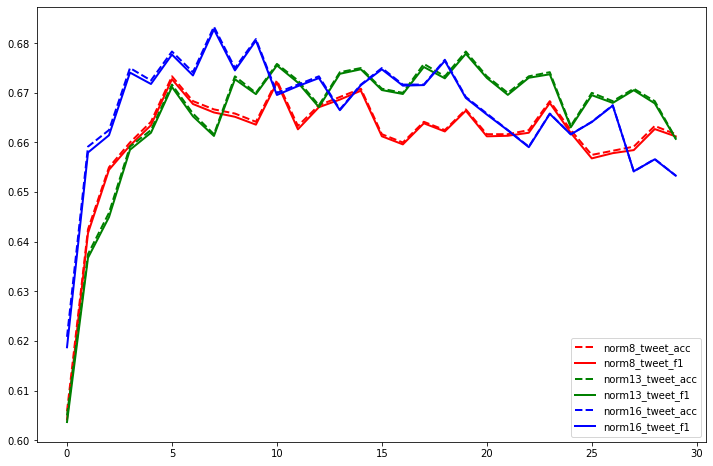

In [51]:
plot_line_graph_data_tuning([xgb_accuracy8, xgb_accuracy13, xgb_accuracy16],
                            [xgb_f1s8, xgb_f1s13, xgb_f1s16], labels)

# Innovations

### Ensemble Classification




#### Import Packages

In [52]:
from sklearn.ensemble import StackingClassifier

#### Stacked Classifier

In [53]:
# norm8 tweets
metrics_df = pd.DataFrame.from_dict(logs[labels[0]]['metrics'])
metrics_df.sort_values(by=['f1 score'], axis=1, ascending=False, inplace=False)

,extree,logreg,svm,xgboost,nb,randforest,dectree,knn
accuracy,69.750000,69.000000,68.250000,67.333333,67.250000,61.833333,57.416667,58.00000
f1 score,69.617285,68.935094,68.117936,67.275189,67.104054,61.629309,57.045919,56.47433


In [54]:
# norm13 tweets
metrics_df = pd.DataFrame.from_dict(logs[labels[1]]['metrics'])
metrics_df.sort_values(by=['f1 score'], axis=1, ascending=False, inplace=False)

,extree,svm,xgboost,logreg,nb,randforest,knn,dectree
accuracy,69.750000,69.166667,67.833333,67.583333,67.500000,63.833333,58.083333,56.333333
f1 score,69.625499,69.035981,67.787145,67.449807,67.353621,63.781453,56.581430,56.261545


In [55]:
# norm16 tweets
metrics_df = pd.DataFrame.from_dict(logs[labels[2]]['metrics'])
metrics_df.sort_values(by=['f1 score'], axis=1, ascending=False, inplace=False)

,svm,logreg,extree,xgboost,nb,randforest,dectree,knn
accuracy,69.666667,69.166667,68.833333,68.333333,66.583333,62.916667,58.25000,59.166667
f1 score,69.549540,69.048097,68.696350,68.279377,66.542296,62.797846,58.23008,57.803304


In [56]:
stacked_estimators = [
                      ('xgb', XGBClassifier(max_depth = optimal_xgb_depth, n_estimators = 250, random_state = SEED)),
                      ('et', ExtraTreesClassifier(max_depth = optimal_et_depth, n_estimators = 250, random_state = SEED)),
                      ('svm', SVC(C = 1, gamma = 1, kernel = 'rbf')),
                      ('nb', MultinomialNB(alpha = 1))
                     ]

In [57]:
final_est = LogisticRegression(solver = 'saga', multi_class = 'multinomial', random_state = SEED)
stacked_clf = StackingClassifier(estimators = stacked_estimators,
                                final_estimator = final_est,
                                n_jobs = 1)

In [58]:
stacked_clf.fit(X_train_dtm13, y_train_encoded)
y_pred_encoded = stacked_clf.predict(X_test_dtm13)
y_pred = le.inverse_transform(y_pred_encoded)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

Accuracy Score: 70.5%
F1 Score: 70.42393881829015%


              precision    recall  f1-score   support

    NEGATIVE       0.68      0.76      0.72       386
     NEUTRAL       0.71      0.72      0.72       424
    POSITIVE       0.72      0.64      0.68       390

    accuracy                           0.70      1200
   macro avg       0.71      0.70      0.70      1200
weighted avg       0.71      0.70      0.70      1200



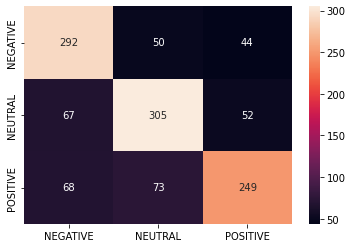

In [59]:
show_metrics(y_test, y_pred)

In [60]:
# Store results
logs[labels[1]]['models']['stacked'] = list(y_pred)
logs[labels[1]]['metrics']['stacked'] = {'accuracy': acc, 'f1 score': f1}

# Discussion

### Experiment Findings

In [61]:
# View test dataset with model results
findings_df = pd.DataFrame.from_dict(logs[labels[1]]['models'])
findings_df = pd.merge(overall_df, findings_df, left_on='index', right_on='index')
findings_df.head()

,tweet,label_1,label_2,label_3,final_label,index,len8_tweet,norm8_tweet,len13_tweet,norm13_tweet,...,y_test,knn,logreg,nb,svm,dectree,extree,randforest,xgboost,stacked
0,iphone features appleevent you must buy it,POSITIVE,POSITIVE,POSITIVE,POSITIVE,9,iphone features appleevent you must buy it,iphone features appleevent you must buy it,iphone features appleevent you must buy it,iphone features appleevent you must buy it,...,POSITIVE,NEUTRAL,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE
1,hey this is real dope appleevent,POSITIVE,POSITIVE,POSITIVE,POSITIVE,12,hey this is real dope appleevent,hey this is real dope appleevent,hey this is real dope appleevent,hey this is real dope appleevent,...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE
2,thank you so much for this amazing opportunity,POSITIVE,POSITIVE,POSITIVE,POSITIVE,14,thank you so much for this amazing opportunity,thank you so much for this amazing opportunity,thank you so much for this amazing opportunity,thank you so much for this amazing opportunity,...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE
3,top best laptops for nursing school students,POSITIVE,POSITIVE,POSITIVE,POSITIVE,17,top best laptops for nursing school students,top best laptops for nursing school students,top best laptops for nursing school students,top best laptops for nursing school students,...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE
4,thoughtsol and apple together bring you the al...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,18,thoughtsol apple together bring new apple watc...,thoughtsol apple together bring new apple watc...,thoughtsol and apple together bring you the al...,thoughtsol and apple together bring you the al...,...,POSITIVE,NEUTRAL,NEGATIVE,NEUTRAL,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE


In [62]:
# Sort base on f1 score
metrics_df = pd.DataFrame.from_dict(logs[labels[1]]['metrics'])
metrics_df.sort_values(by=['f1 score'], axis=1, ascending=False, inplace=False)

,stacked,extree,svm,xgboost,logreg,nb,randforest,knn,dectree
accuracy,70.500000,69.750000,69.166667,67.833333,67.583333,67.500000,63.833333,58.083333,56.333333
f1 score,70.423939,69.625499,69.035981,67.787145,67.449807,67.353621,63.781453,56.581430,56.261545


### Error Analysis

In [63]:
# Find differences between actual & predicted by our best classifier
error_df = findings_df.loc[~(findings_df['y_test'] == findings_df['stacked'])]

Text(0.5, 1.0, 'Sentence Length Distribution in Error Dataset')

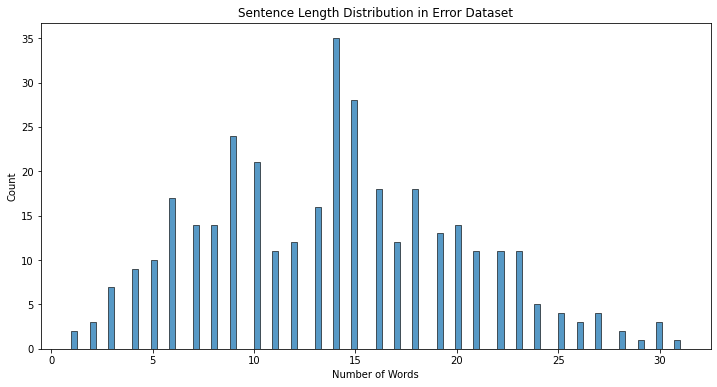

In [64]:
# Bar graph visualisation of word count distribution
plt.figure(figsize=(12,6))
sns.histplot([len(s.split(' ')) for s in error_df['X_test']], bins=100)
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.title("Sentence Length Distribution in Error Dataset")

In [65]:
# Eliminate errors for short normalized tweet length
error_df['short_tweet'] = error_df['X_test'].apply(lambda x: len(x.split(' ')) < 8)
error_df.loc[error_df['short_tweet'] == True][['tweet', 'X_test', 'y_test', 'stacked', 'short_tweet']]

,tweet,X_test,y_test,stacked,short_tweet
8,dominating the news this week here iphone,dominating the news this week here iphone,POSITIVE,NEUTRAL,True
22,macbook air schematic wallpapers appleevent,macbook air schematic wallpapers appleevent,POSITIVE,NEUTRAL,True
33,finally iphonepro is here appleevent iphone,finally iphonepro is here appleevent iphone,POSITIVE,NEUTRAL,True
83,testing the apple world applewatchseries,testing the apple world applewatchseries,POSITIVE,NEUTRAL,True
137,iphonepro get,iphonepro get,POSITIVE,NEUTRAL,True
...,...,...,...,...,...
1150,the iphone pro max too big,the iphone pro max too big,NEGATIVE,NEUTRAL,True
1164,sister just ordered iphone for me,sister just ordered iphone for me,NEUTRAL,NEGATIVE,True
1184,ima be dead honest tho iphonepro,ima be dead honest tho iphonepro,NEUTRAL,NEGATIVE,True
1192,no i want iphonepromax,no i want iphonepromax,POSITIVE,NEGATIVE,True
